In [1]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

2022-07-18 15:58:34.444920: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler

from util import *

# 멀티 헤드 어텐션

In [3]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value, mask):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        if mask is not None:
            logits += (mask * -1e9)#더하는 연산의 형태지만, 마스크 위치가 -1e9로 교체됨!
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, mask=None, query_=None):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        if query_ is None:
            query = self.query_dense(inputs)
        else:
            query = self.query_dense(query_)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

In [ ]:
logits = tf.constant([[1.1, 1.2, 1.3, 1.4, 1.5],
                      [2.1, 2.2, 2.3, 2.4, 2.5],
                      [3.1, 3.2, 3.3, 3.4, 3.5],
                      [4.1, 4.2, 4.3, 4.4, 4.5],
                      [5.1, 5.2, 5.3, 5.4, 5.5]])

mask = 1 - tf.linalg.band_part(tf.ones((5,5)), -1, 0)
print(mask)
logits += (mask*-1e9)
logits

# 인코더 레이어(트랜스포머 블록)

In [5]:
class encoder_layer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1,**kwargs):
        super(encoder_layer, self).__init__(**kwargs)
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

# 포지션 임베딩

In [6]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# 에셋 임베딩 레이어

In [50]:
#max_len = 문장 최대 길이 -> window_size로
#vocab_size = 빈도수 상위 2만개의 단어만 사용 -> 뭐로 해야하지? window_size 통일?
#어쩌면 필요없을지도?? : 토큰을 안쓰니까?  -> Dense레이어와 같은 기능이니 Dense를 쓰자!!!

class AssetAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, window_size, embedding_dim, is_decoder=False, **kwargs):
        super(AssetAndPositionEmbedding, self).__init__(**kwargs)
        self.esset_emb = tf.keras.layers.Dense(embedding_dim) #입력 데이터 shape : (batch_size, window_size)
        self.pos_emb = tf.keras.layers.Embedding(window_size, embedding_dim)
        self.is_decoder = is_decoder
        self.__windowsize = window_size

    def call(self, x):
        L = tf.shape(x)[1] if self.is_decoder else self.__windowsize
        
        positions = tf.range(start=0, limit= L, delta=1)
        positions = self.pos_emb(positions)
        x = tf.reshape(x,(-1,L,1))
        x = self.esset_emb(x)
        return x + positions

In [36]:
tmp = np.array([1.0,1.1,1.2,1.3,1.4,2.0,2.1,2.2,2.3,2.4,3.0,3.1,3.2,3.3,3.4]).reshape((3,5,-1))

l = tf.keras.layers.Dense(10)
l2 = tf.keras.layers.Embedding(5, 10)
print(tmp)

positions = tf.range(start=0, limit=5, delta=1)
positions = l2(positions)
tmp = l(tmp)
print(tmp + positions)

[[[1. ]
  [1.1]
  [1.2]
  [1.3]
  [1.4]]

 [[2. ]
  [2.1]
  [2.2]
  [2.3]
  [2.4]]

 [[3. ]
  [3.1]
  [3.2]
  [3.3]
  [3.4]]]
tf.Tensor(
[[[ 0.4523935   0.4598292  -0.15886037  0.03549526 -0.3173228
   -0.09508678  0.508489    0.24741486 -0.13972902  0.5420162 ]
  [ 0.41738394  0.57991946 -0.16047908  0.10164823 -0.26964748
   -0.10680608  0.4818846   0.24162196 -0.15555464  0.60984623]
  [ 0.49950382  0.6160503  -0.09524913  0.08870602 -0.32093856
   -0.1699338   0.6007443   0.20210837 -0.23825511  0.7190665 ]
  [ 0.5700511   0.6675504  -0.16355692  0.0415335  -0.38937348
   -0.16037449  0.6516839   0.23781939 -0.20278558  0.77496713]
  [ 0.5787501   0.75824237 -0.15133947  0.13062789 -0.35028574
   -0.14232355  0.62190026  0.26112363 -0.28286847  0.8067177 ]]

 [[ 0.8565283   0.9660588  -0.2737403   0.10530225 -0.5918258
   -0.20582554  0.98139316  0.45434555 -0.306081    1.1273571 ]
  [ 0.8215187   1.086149   -0.27535897  0.1714552  -0.5441504
   -0.21754481  0.9547887   0.44855264 

# 디코더

## 룩-어헤드-마스크
(디코더에서 미래토큰을 이용해 attention 못하게 하는 것!)

In [9]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return look_ahead_mask

In [54]:
tmp = tf.constant([[1,2,3,4,5],
                   [0,9,8,7,6]])


emb = AssetAndPositionEmbedding(20,10,is_decoder = True)
att1 = MultiHeadAttention(10, 1)
l = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None))
q = tf.keras.layers.Dense(10)
k = tf.keras.layers.Dense(10)
v = tf.keras.layers.Dense(10)

tmp_ = emb(tmp)
mask_ = l(tmp)
#query = q(tmp_)
#key = k(tmp_)
#value = v(tmp_)
att1(tmp_,mask = mask_)


<tf.Tensor: shape=(2, 5, 10), dtype=float32, numpy=
array([[[-1.2092302e+00,  6.8527006e-02,  3.3292103e-01,  1.8105343e-02,
         -2.4868713e-01, -1.0898347e-01, -3.4640485e-01, -5.3709531e-01,
          4.4816291e-01, -4.2409912e-02],
        [-1.9582322e+00,  6.3578069e-02,  5.4038769e-01, -2.9455081e-02,
         -3.3842540e-01, -2.0657477e-01, -5.3563964e-01, -7.8727436e-01,
          7.5678116e-01, -3.0719399e-02],
        [-2.9663196e+00,  1.2378515e-01,  8.2149392e-01, -3.8793907e-02,
         -5.3107023e-01, -2.9298228e-01, -8.1717157e-01, -1.1688446e+00,
          1.1333616e+00, -4.7983289e-02],
        [-4.1283822e+00,  1.8938079e-01,  1.1111833e+00, -9.3164951e-02,
         -7.2616273e-01, -3.7265843e-01, -1.1431520e+00, -1.5595028e+00,
          1.5723670e+00, -8.1279278e-02],
        [-5.4032607e+00,  2.6441628e-01,  1.4210113e+00, -1.2298635e-01,
         -9.6166712e-01, -4.5767057e-01, -1.5173202e+00, -2.0524879e+00,
          2.0549111e+00, -1.3684571e-01]],

      

## 디코더 레이어

In [11]:
class decoder_layer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1,**kwargs):
        super(decoder_layer, self).__init__(**kwargs)
        self.att1 = MultiHeadAttention(embedding_dim, num_heads)
        self.att2 = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None))
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, inputs:list):
        dec_inputs, enc_outputs = inputs
        
        look_ahead_mask = self.look_ahead_mask(dec_inputs)
        attn_output_1 = self.att1(dec_inputs,mask = look_ahead_mask) # 첫번째 서브층 : 멀티 헤드 어텐션 / 마스크 포함
        out1 = self.layernorm1(dec_inputs + attn_output_1) # Add & Norm
        
        attn_output_2 = self.att2(enc_outputs,query_ = out1) # 두번째 서브층 : 멀티 헤드 어텐션 / Q != K = V
        attn_output_2 = self.dropout2(attn_output_2)
        out2 = self.layernorm2(out1 + attn_output_2) # Add & Norm
        
        ffn_output = self.ffn(out2) # 세번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout3(ffn_output)
        return self.layernorm3(out2 + ffn_output) # Add & Norm

# 데이터로드 및 전처리

## 기본 형태(IMDB 리뷰 분류)

In [12]:
vocab_size = 20000  # 빈도수 상위 2만개의 단어만 사용
max_len = 200  # 문장의 최대 길이

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))

훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000


In [13]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

In [14]:
X_train[0]

array([    5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,    14,   407,    16,    82, 10311,     8,     4,
         107,   117,  5952,    15,   256,     4,     2,     7,  3766,
           5,   723,

## 기존 전체 에셋의 주가 dataframe(Date, Adj Close)

In [15]:
path = "./stock"
csvList=os.listdir(path+"/asset")

#include_list = []

for csv in csvList:
    if csv[-4:] != ".csv":
        continue

    data=pd.read_csv(path+"/asset"+'/'+csv)
    if(len(data)>2000):
        data=data[-2000-1:-1]
        data=data.reset_index()
        data=data[['Date','Adj Close']]
        data.columns = ['Date',csv[:-4]]

        #include_list.append(csv[:-4])

        if csv == csvList[0]:
            dataframe = data
        else:
            dataframe = pd.merge(dataframe,data,how="outer",on="Date")

dataframe["Date"] = pd.to_datetime(dataframe["Date"])
dataframe.sort_values(by=['Date'],inplace=True)
dataframe.fillna(method='ffill',inplace=True)
dataframe.fillna(method='bfill',inplace=True)
sort_asset = dataframe.columns.to_list()[1:]
sort_asset.sort()
sort_col = ["Date"]
sort_col.extend(sort_asset)
dataframe = dataframe[sort_col]

print(f'period : {dataframe["Date"].iloc[0]} ~ {dataframe["Date"].iloc[-1]}')
dataT=dataframe.drop(columns = "Date").copy()

period : 2014-05-21 00:00:00 ~ 2022-04-28 00:00:00


In [16]:
dataframe

,Date,ABBV,ACN,AEP,AIZ,ALLE,AMAT,AMP,AMZN,AVB,...,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,XOM
2000,2014-05-21,38.150940,69.072014,38.695145,56.188667,46.928638,17.844561,90.965179,15.250500,107.492188,...,40.704945,67.940010,15.156129,45.362705,32.853657,35.573677,31.551863,51.291527,57.980255,70.825287
2001,2014-05-22,38.408752,69.141609,38.982849,56.400581,47.650467,17.746414,91.312065,15.245500,107.130859,...,40.798111,67.875244,15.225430,45.448112,32.915871,35.517445,31.810246,51.597702,58.287167,70.457397
2002,2014-05-23,38.637936,69.437508,38.922279,56.425999,48.548134,17.880249,91.617661,15.612000,107.668976,...,41.145363,67.738541,15.273937,45.738514,33.191429,35.573677,31.734251,51.623951,58.747547,70.332443
2003,2014-05-27,38.666592,69.707306,39.898937,57.358372,48.557404,18.362055,92.022346,15.541000,108.099503,...,41.145363,67.925598,15.405615,45.977665,33.475883,35.670090,31.985022,51.903896,59.054466,70.360222
2004,2014-05-28,38.723877,69.254768,40.080639,57.121040,48.992348,18.326368,91.824127,15.508000,107.830421,...,41.162308,68.040703,15.377890,46.011822,33.386993,35.621876,32.174999,51.755173,58.991276,70.151962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2022-04-22,154.990005,310.799988,99.465302,185.865387,114.046402,112.524857,278.786682,144.350006,248.825989,...,85.150620,75.354942,35.978214,97.999741,142.709152,78.649414,73.660530,133.108063,175.414368,84.266830
1996,2022-04-25,156.300003,316.820007,99.713348,186.453156,114.255547,114.190781,279.662628,146.074005,246.415588,...,84.912270,72.862892,36.037895,97.999741,144.853577,78.996803,73.154579,134.004288,176.681427,81.425934
1997,2022-04-26,156.179993,303.100006,98.463203,184.191727,113.767532,108.654312,263.328400,139.391006,242.378433,...,83.601341,72.961784,35.132721,95.859138,139.457611,77.775970,72.420456,131.644241,167.742111,81.455627
1998,2022-04-27,157.619995,303.100006,98.750938,185.317459,115.550278,108.544579,264.980743,138.167007,238.837234,...,84.832817,74.029808,35.102882,96.217567,141.522232,78.063812,72.073235,131.355469,167.762054,83.781799


In [17]:
start_date='2012-03-01'
end_date="2022-05-01"
INDEX_DATA = make_index_data(start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## ABBV 데이터(Date, Open, High, Low, Close, Adj Close, Vloume)

In [18]:
ABBV = pd.read_csv("./stock/asset/ABBV.csv")
ABBV

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,34.919998,35.400002,34.099998,35.119999,23.783308,13767900
1,2013-01-03,35.000000,35.000000,34.160000,34.830002,23.586918,16739300
2,2013-01-04,34.619999,34.889999,34.250000,34.389999,23.288939,21372100
3,2013-01-07,34.150002,35.450001,34.150002,34.459999,23.336348,17897100
4,2013-01-08,34.290001,34.639999,33.360001,33.709999,22.828451,17863300
...,...,...,...,...,...,...,...
2344,2022-04-25,154.839996,156.639999,152.839996,156.300003,156.300003,6932600
2345,2022-04-26,156.440002,159.690002,155.820007,156.179993,156.179993,6787800
2346,2022-04-27,156.559998,159.500000,154.559998,157.619995,157.619995,6039100
2347,2022-04-28,158.360001,158.440002,154.339996,156.309998,156.309998,7465000


In [19]:
class one_asset:
    def __init__(self, asset_dataframe, X_col=["Adj Close"], window_size=20 ,H = 1, train_test_ratio = 0.8, is_minmaxscale = False):
        self.origin_data = asset_dataframe
        self.X_col = X_col
        self.window_size = window_size
        self.H = H
        self.train_test_ratio = train_test_ratio
        self.__split_point = int(self.origin_data.shape[0]*0.7)
        self.scaler = MinMaxScaler(feature_range = (-1,+1)) if is_minmaxscale else None
        
        self.dataframe = self.origin_data.drop(columns="Date").copy()
        self.dataframe.fillna(method='ffill',inplace=True)
        self.dataframe.fillna(method='bfill',inplace=True)
        if self.scaler is not None:
            self.scaler.fit(self.dataframe)
            self.dataframe = self.scaler.transform(self.dataframe)
            self.dataframe = pd.DataFrame(self.dataframe)
            self.dataframe.columns = self.origin_data.columns[1:]

    def get_data(self, is_numpy = True, is_train = True):
        if is_train:
            dataframe = self.dataframe.iloc[:self.__split_point,:].copy()
        else:
            dataframe = self.dataframe.iloc[self.__split_point-self.window_size-self.H-1:,:].copy()

        X_data = dataframe[self.X_col].iloc[:-self.H,:].copy()
        Y_data = dataframe[["Adj Close"]].iloc[self.H + self.window_size-1:,:].copy()

        if is_numpy:
            return X_data.to_numpy(), Y_data.to_numpy()
        else:
            return X_data, Y_data

    def get_data_for_model(self, is_train = True, is_shuffle=True):
        X_np,Y_np = self.get_data(is_train = is_train)
        if is_train:
            start_point_array = np.arange(Y_np.shape[0])
            if is_shuffle:
                np.random.shuffle(start_point_array)
            X_data = []
            for sp in start_point_array:
                X_data.append(list(X_np[sp:sp+self.window_size]))
            X_data = np.array(X_data)
            Y_data = Y_np[start_point_array]

            return X_data, Y_data
        else:
            start_point_array = np.arange(Y_np.shape[0])
            X_data = []
            for sp in start_point_array:
                X_data.append(X_np[sp:sp+self.window_size])
            X_data = np.array(X_data)
            Y_data = Y_np

            return X_data, Y_data

    def get_data_long_y(self, length_y = 20 ,is_train = True, is_shuffle=True):
        X_np,Y_np = self.get_data(is_train = is_train)
        Y_np = np.concatenate([X_np[-Y_np.shape[0]].reshape((1,1)),Y_np.reshape((-1,1))],axis=0)
        if is_train:
            start_point_array = np.arange(Y_np.shape[0])
            for ind in start_point_array:
                if ind+length_y+1 > Y_np.shape[0]:
                    start_point_array = start_point_array[start_point_array != ind]
            
            if is_shuffle:
                np.random.shuffle(start_point_array)
            X_data = []
            for sp in start_point_array:
                X_data.append(list(X_np[sp:sp+self.window_size]))
            X_data = np.array(X_data)
            
            Y_data = []
            for sp in start_point_array:
                Y_data.append(list(Y_np[sp:sp+length_y+1]))
            Y_data = np.array(Y_data)
            
            return X_data, Y_data
        else:
            start_point_array = np.arange(Y_np.shape[0])
            for ind in start_point_array:
                if ind+length_y+1 > Y_np.shape[0]:
                    start_point_array = start_point_array[start_point_array != ind]
            X_data = []
            for sp in start_point_array:
                X_data.append(X_np[sp:sp+self.window_size])
            X_data = np.array(X_data)
            
            Y_data = []
            for sp in start_point_array:
                Y_data.append(list(Y_np[sp:sp+length_y+1]))
            Y_data = np.array(Y_data)

            return X_data, Y_data

In [20]:
tmp = np.array([0,1,2,3,4])
for t in tmp:
    if t+3 > tmp.shape[0]:
        tmp = tmp[tmp != t]
tmp

array([0, 1, 2])

In [21]:
abbv_1 = one_asset(ABBV,X_col=["Adj Close"], window_size=20 ,H = 1, train_test_ratio = 0.8)
X,Y = abbv_1.get_data(is_train = True)
print(X.shape, Y.shape)
X_1,Y_1 = abbv_1.get_data_for_model(is_train = True)
print(X_1.shape,Y_1.shape)

(1643, 1) (1624, 1)
(1624, 20, 1) (1624, 1)


In [22]:
print(X.squeeze()[:24], Y.squeeze()[:4])

[23.78330803 23.58691788 23.28893852 23.33634758 22.82845116 22.95711708
 23.02483559 23.19614792 23.36061287 23.71010017 24.35425377 24.95727158
 25.57401276 24.95727158 25.90294075 25.66995049 25.76588821 25.27934837
 25.56716537 25.3067646  25.14229965 25.47807693 25.54659653 25.49178123] [25.14229965 25.47807693 25.54659653 25.49178123]


# 모델

## 모델 생성

In [23]:
tf.keras.backend.clear_session()

In [51]:
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

window_size = 25

#inputs = tf.keras.layers.Input(shape=(max_len,))
inputs = tf.keras.layers.Input(shape=(window_size,),name="input")
#embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
embedding_layer = AssetAndPositionEmbedding(window_size, embedding_dim,name = "asset_and_position_Embedding")
x = embedding_layer(inputs)
transformer_block = encoder_layer(embedding_dim, num_heads, dff, name = "encoder_layer")
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D(name = "pooling_1")(x)
x = tf.keras.layers.Dropout(0.1,name="drop_out_1")(x)
x = tf.keras.layers.Dense(20, activation="relu",name="Dense_1")(x)
x = tf.keras.layers.Dropout(0.1,name="drop_out_2")(x)
outputs = tf.keras.layers.Dense(2, activation="softmax",name="Dense_2")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [62]:
def transformer_stock(embedding_dim, num_heads, dff, window_size, forecast_range, name="Transformer_Stock"):
    #레이어 구성
    inputs = tf.keras.layers.Input(shape=(window_size,),name="encoder_input")
    decoder_inputs = tf.keras.layers.Input(shape=(None,),name="decoder_input")
    embedding_layer_encoder = AssetAndPositionEmbedding(window_size, embedding_dim,name = "Encoder_Embedding")
    embedding_layer_decoder = AssetAndPositionEmbedding(forecast_range, embedding_dim,is_decoder = True, name = "Decoder_Embedding")
    encoder_block = encoder_layer(embedding_dim, num_heads, dff, name = "encoder_layer")
    decoder_block = decoder_layer(embedding_dim, num_heads, dff, name = "decoder_layer")
    final_dence = tf.keras.layers.Dense(1,name = "Final_Dense")
    
    #모델 쌓기
    encoder_embeding_out = embedding_layer_encoder(inputs)
    encoder_out = encoder_block(encoder_embeding_out)
    decoder_embeding_out = embedding_layer_decoder(decoder_inputs)
    decoder_out = decoder_block(inputs = [decoder_embeding_out, encoder_out])#바로 위랑 함께 for문으로 묶어야하나...?
    final_out = final_dence(decoder_out)
    
    return tf.keras.Model(inputs=[inputs,decoder_inputs], outputs=final_out, name = name)

In [63]:
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

window_size = 25
forecast_range = 20

model = transformer_stock(embedding_dim, num_heads, dff, window_size, forecast_range)

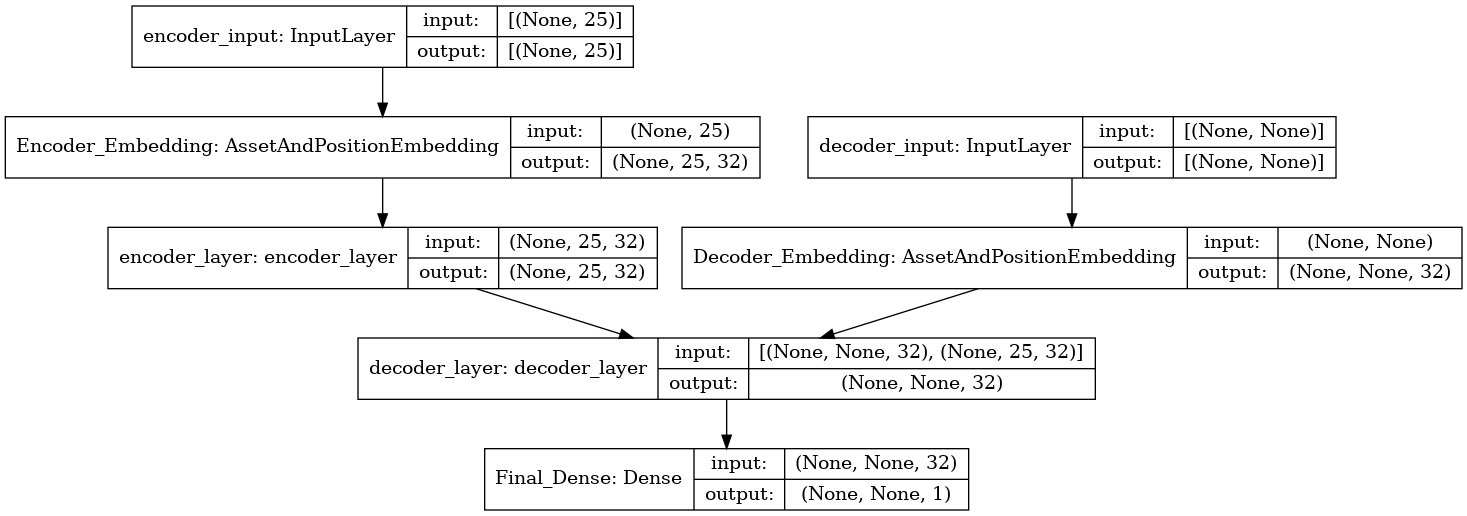

In [64]:
tf.keras.utils.plot_model(model, show_shapes=True)

## 데이터 셋 생성 

In [27]:
abbv_1 = one_asset(ABBV,X_col=["Adj Close"], window_size=25 ,H = 1, train_test_ratio = 0.8,is_minmaxscale=True)
X,Y = abbv_1.get_data(is_train = True)
print(X.shape, Y.shape)
X_1,Y_1 = abbv_1.get_data_long_y(is_train = True,is_shuffle=True)
print(X_1.shape,Y_1.shape)
X_2,Y_2 = abbv_1.get_data_long_y(is_train = False)
print(X_2.shape,Y_2.shape)

(1643, 1) (1619, 1)
(1600, 25, 1) (1600, 21, 1)
(688, 25, 1) (688, 21, 1)


In [28]:
Y_1.squeeze()[:,:-1].shape

(1600, 20)

In [29]:
X_train_asset = X_1.squeeze()
y_train_asset = Y_1.squeeze()

X_test_asset = X_2.squeeze()
y_test_asset = Y_2.squeeze()

print(X_train_asset.shape, y_train_asset.shape, X_test_asset.shape, y_test_asset.shape)

(1600, 25) (1600, 21) (688, 25) (688, 21)


In [30]:
print(X_train_asset[:3])
print()
print(y_train_asset[:3])

[[-0.79659119 -0.79316869 -0.79012624 -0.78974582 -0.78898535 -0.78936551
  -0.78651337 -0.78822447 -0.78613306 -0.78413649 -0.77729113 -0.77919254
  -0.79117202 -0.78993608 -0.787464   -0.79288343 -0.78812962 -0.78965077
  -0.78679863 -0.78423155 -0.78784436 -0.79630588 -0.7920276  -0.79354869
  -0.78014342]
 [-0.30240205 -0.30477214 -0.33377808 -0.39404711 -0.43242108 -0.42869645
  -0.41075107 -0.39686881 -0.39449892 -0.41673287 -0.4036405  -0.41052532
  -0.40950977 -0.40386636 -0.40273788 -0.40093203 -0.3912257  -0.39427296
  -0.39054843 -0.39427296 -0.40025476 -0.41424985 -0.39991637 -0.39686881
  -0.39438589]
 [-0.6194738  -0.62895553 -0.62401714 -0.62609138 -0.62500468 -0.6178935
  -0.62293079 -0.62559753 -0.63656071 -0.65216623 -0.67636463 -0.70342722
  -0.67942637 -0.665895   -0.67112984 -0.68663651 -0.70550121 -0.70076032
  -0.69483424 -0.71271135 -0.70480997 -0.71774864 -0.714588   -0.71685969
  -0.72090913]]

[[-0.78014342 -0.76578721 -0.76312492 -0.76645258 -0.76217434 -0.7

In [129]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'encoder_input': X_1.squeeze(),
        'decoder_input': Y_1.squeeze()[:, :-1] # 디코더의 입력. 마지막 값이 제거된다.(t 시점 ~ t+19 시점)
    },
    {
        'Final_Dense': Y_1[:,:-1,:]  # 맨 처음 토큰이 제거된다. 다시 말해 input의 마지막 값이 제거된다.(t+1 시점 ~ t+20 시점)
    },
))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [130]:
# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'encoder_input': X_2.squeeze(),
        'decoder_input': Y_2.squeeze()[:, :-1] # 디코더의 입력. 마지막 값이 제거된다.(t 시점 ~ t+19 시점)
    },
    {
        'Final_Dense': Y_2[:,:-1,:]  # 맨 처음 토큰이 제거된다. 다시 말해 input의 마지막 값이 제거된다.(t+1 시점 ~ t+20 시점)
    },
))

test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 모델 컴파일

In [60]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsolutePercentageError()]
             )

# 학습

In [61]:
#history = model.fit(X_train_asset, y_train_asset, batch_size=32, epochs=10, validation_data=(X_test_asset, y_test_asset))
history = model.fit(train_dataset, batch_size=32, epochs=200, validation_data=test_dataset)

Epoch 1/200
25/25 [==============================] - 1s 56ms/step - loss: 1.5484 - root_mean_squared_error: 1.1830 - mean_absolute_percentage_error: 287.7373 - val_loss: 0.2400 - val_root_mean_squared_error: 0.4899 - val_mean_absolute_percentage_error: 1079.0712
Epoch 2/200
25/25 [==============================] - 2s 66ms/step - loss: 0.1286 - root_mean_squared_error: 0.3582 - mean_absolute_percentage_error: 109.0620 - val_loss: 0.6076 - val_root_mean_squared_error: 0.7795 - val_mean_absolute_percentage_error: 760.1453
Epoch 3/200
25/25 [==============================] - 2s 67ms/step - loss: 0.0721 - root_mean_squared_error: 0.2684 - mean_absolute_percentage_error: 59.9557 - val_loss: 1.1811 - val_root_mean_squared_error: 1.0868 - val_mean_absolute_percentage_error: 1214.6069
Epoch 4/200
25/25 [==============================] - 2s 60ms/step - loss: 0.0489 - root_mean_squared_error: 0.2210 - mean_absolute_percentage_error: 52.7849 - val_loss: 0.6853 - val_root_mean_squared_error: 0.8278

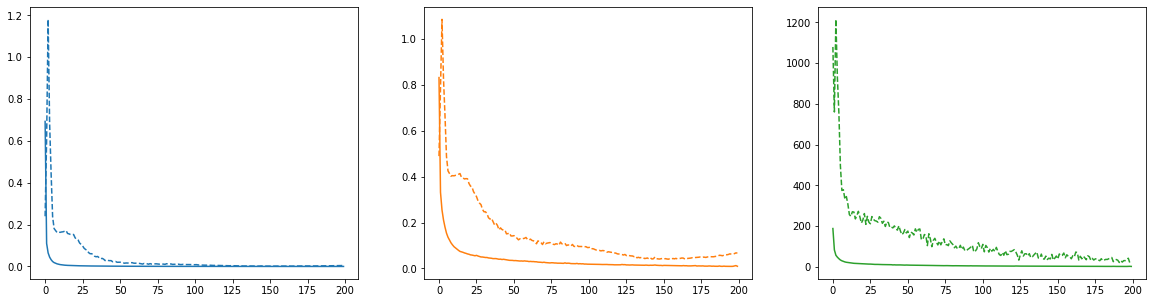

In [81]:
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.plot(history.history['loss'],"C0-")
ax1.plot(history.history['val_loss'],"C0--")

ax2.plot(history.history['root_mean_squared_error'],"C1-")
ax2.plot(history.history['val_root_mean_squared_error'],"C1--")

ax3.plot(history.history['mean_absolute_percentage_error'],"C2-")
ax3.plot(history.history['val_mean_absolute_percentage_error'],"C2--")


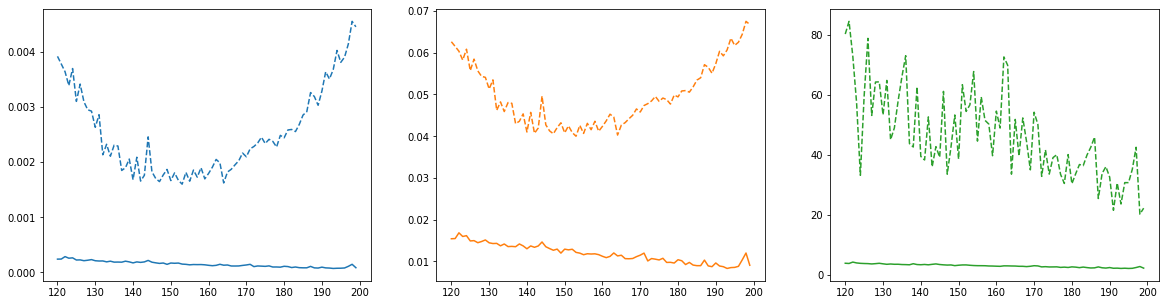

In [87]:
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

sp, ep = 120, 200

ax1.plot(range(sp,ep),history.history['loss'][sp:ep],"C0-")
ax1.plot(range(sp,ep),history.history['val_loss'][sp:ep],"C0--")

ax2.plot(range(sp,ep),history.history['root_mean_squared_error'][sp:ep],"C1-")
ax2.plot(range(sp,ep),history.history['val_root_mean_squared_error'][sp:ep],"C1--")

ax3.plot(range(sp,ep),history.history['mean_absolute_percentage_error'][sp:ep],"C2-")
ax3.plot(range(sp,ep),history.history['val_mean_absolute_percentage_error'][sp:ep],"C2--")

# 어째서 잘 되는지 모르겠으면 개추  
ㅇㄷㄴㅂㅌ

In [138]:
X_2.squeeze()[-1]

array([0.66538872, 0.6420899 , 0.64103677, 0.66578371, 0.67684083,
       0.67881541, 0.66420413, 0.63392843, 0.65617452, 0.66051829,
       0.65907037, 0.69908692, 0.74884414, 0.75108186, 0.78451673,
       0.79254634, 0.80373512, 0.80320845, 0.78227902, 0.80676262,
       0.82058412, 0.82900872, 0.8317729 , 0.85243941, 0.83085164])

In [135]:
Y_2[-1,:,:].squeeze()

array([0.83085164, 0.83835458, 0.8279556 , 0.8482269 , 0.92036208,
       0.97788557, 1.        , 0.93247232, 0.89930078, 0.80703811,
       0.85164273, 0.81248098, 0.77252276, 0.77716895, 0.80132988,
       0.75446851, 0.77185896, 0.7702658 , 0.7893821 , 0.77199164,
       0.64680679])

In [133]:
ABBV["Adj Close"][-21:]

2328    160.743835
2329    161.309021
2330    160.525681
2331    162.052689
2332    167.486526
2333    171.819687
2334    173.485535
2335    168.398773
2336    165.900009
2337    158.949997
2338    162.309998
2339    159.360001
2340    156.350006
2341    156.699997
2342    158.520004
2343    154.990005
2344    156.300003
2345    156.179993
2346    157.619995
2347    156.309998
2348    146.880005
Name: Adj Close, dtype: float64

In [134]:
tmp = Y_2[-1,:,:].squeeze().copy()

tmp -= abbv_1.scaler.min_[4]
tmp /= abbv_1.scaler.scale_[4]
tmp

array([160.74383545, 161.309021  , 160.52568054, 162.0526886 ,
       167.48652649, 171.81968689, 173.48553467, 168.39877319,
       165.90000916, 158.94999695, 162.30999756, 159.36000061,
       156.3500061 , 156.69999695, 158.52000427, 154.99000549,
       156.30000305, 156.17999268, 157.61999512, 156.30999756,
       146.88000488])

In [168]:
tmp1 = np.array([[1,2,3,4,5]])
tmp2 = np.array([[5,6,7]])
fore1 = 8

tmp1 = np.append(tmp1[0,1:],tmp2[0,1])
tmp2 = np.append(tmp2[0,1:],fore1)

print(tmp1,tmp2)

[2 3 4 5 6] [6 7 8]


In [194]:
total_range = abbv_1.dataframe["Adj Close"].to_numpy()[-(25+20+20-1):].copy()
enc_input = total_range[:25]
dec_input = total_range[25-1:25-1+20]
print(enc_input,enc_input.shape)
print(dec_input,dec_input.shape)
print(abbv_1.dataframe["Adj Close"].to_numpy()[-21:].copy())

[0.51243123 0.49887307 0.50032099 0.52164543 0.54942008 0.54836695
 0.5731141  0.58601393 0.5819335  0.57548348 0.56626908 0.57930078
 0.60246814 0.61707942 0.60523252 0.59285894 0.61299879 0.62879467
 0.60918149 0.66538872 0.6420899  0.64103677 0.66578371 0.67684083
 0.67881541] (25,)
[0.67881541 0.66420413 0.63392843 0.65617452 0.66051829 0.65907037
 0.69908692 0.74884414 0.75108186 0.78451673 0.79254634 0.80373512
 0.80320845 0.78227902 0.80676262 0.82058412 0.82900872 0.8317729
 0.85243941 0.83085164] (20,)
[0.83085164 0.83835458 0.8279556  0.8482269  0.92036208 0.97788557
 1.         0.93247232 0.89930078 0.80703811 0.85164273 0.81248098
 0.77252276 0.77716895 0.80132988 0.75446851 0.77185896 0.7702658
 0.7893821  0.77199164 0.64680679]


## 실제 상황 가정하고 20시점 예측

In [195]:
def evaluate(asset_1:one_asset, H=20, window_size=25):
    '''
    실제 상황 가정하고 예측!
    
    파라미터:
        asset_1 : one_asset 클래스로 만들어진 데이터
        H : 예측할 시점 길이(decoder_input의 길이와 같음)
        window_size : encoder_input 길이
    '''
    #(enc_input길이 + dec_input길이 + 예측 길이-1)
    total_range = asset_1.dataframe["Adj Close"].to_numpy()[-(window_size+H+H-1):].copy()
    y_true = asset_1.origin_data["Adj Close"].to_numpy()[-H:].copy()
    
    #첫 입력 모양
    enc_input = total_range[:window_size]
    dec_input = total_range[window_size-1:window_size-1+H]
    
    #결과 기록
    result = np.array([])

    # 디코더의 예측 시작
    for i in range(H):
        forecasts = model(inputs=[enc_input.reshape((1,-1)), dec_input.reshape((1,-1))], training=False)

        # 마지막 예측 값을 가져온다
        last_forecast = forecasts.numpy().squeeze()[-1].copy()
        #저장
        result = np.append(result,last_forecast)
        
        #다음 데이터 셋 만들기
        enc_input = np.append(enc_input[1:],dec_input[1])
        dec_input = np.append(dec_input[1:],last_forecast)
        
    # 단어 예측이 모두 끝났다면 output을 리턴.
    return result, y_true

In [203]:
print(abbv_1.scaler.min_[4],abbv_1.scaler.scale_[4])

-1.3030518130917623 0.013275180651225689


In [198]:
forecast, y_true = evaluate(abbv_1,20,25)
forecast1 = forecast.copy()

forecast1 -= abbv_1.scaler.min_[4]
forecast1 /= abbv_1.scaler.scale_[4]
forecast1

array([137.67984378, 123.64176927, 114.98479061, 109.76197157,
       106.81905418, 105.15152636, 104.14542937, 103.56227377,
       103.17082587, 102.83873598, 102.62107086, 102.34672935,
       102.02830681, 101.72092501, 101.38338772, 100.94448013,
       100.35229078,  99.68338985,  98.85732217,  97.97057428])

In [199]:
y_true

array([161.309021  , 160.52568054, 162.0526886 , 167.48652649,
       171.81968689, 173.48553467, 168.39877319, 165.90000916,
       158.94999695, 162.30999756, 159.36000061, 156.3500061 ,
       156.69999695, 158.52000427, 154.99000549, 156.30000305,
       156.17999268, 157.61999512, 156.30999756, 146.88000488])

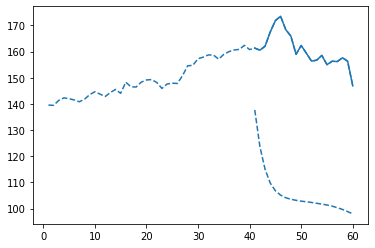

In [202]:
fig = plt.figure()
ax1 = fig.add_subplot()


patial_range = abbv_1.origin_data["Adj Close"].to_numpy()[-60:].copy()


ax1.plot(range(1,61),patial_range,"C0--")
ax1.plot(range(41,61),forecast1,"C0--")
ax1.plot(range(41,61),y_true,"C0-")
